In [35]:
import numpy as np
import pandas as pa
import glob
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import shuffle
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multiclass import OneVsRestClassifier

C:\Users\Shilpa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
activity = ['bending1','bending2', 'cycling', 'lying','sitting' ,'standing','walking' ]
columnn = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
all_features = ["min","max","mean","median","sd","quan0.25","quan0.75"]
columns_name = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23','activities']

In [6]:
#Function for extracting variours time series classification
def features_extract(temp_df):
    features = [] 
    for l in temp_df.columns:
        if l == "activities":
            continue
        s = pa.Series(temp_df[l])
        features += [min(s), max(s), np.mean(s), np.median(s), np.std(s), s.quantile(0.25), s.quantile(0.75)] 
    return features

In [7]:
#Reading the data from the csv file
def read_file(files, act):
    temp_df = pa.read_csv(files, skiprows=range(0, 4), usecols=[1,2,3,4,5,6])
    temp_df["activities"] = act
    temp_df.columns = columns_name 
    return temp_df

In [8]:
#Splitting the dataset for required split values
def split_extract(df, split):
    split_len = int(len(df)/split)
    start = 0
    end = split_len
    recieve = []
    for i in range(split-1):
        start = split_len*i
        end = split_len*(i+1)
        recieve += features_extract(pa.DataFrame(columns = columns_name, data = df.iloc[:end]))
    if split == 1:
        i = 0
    else:
        i+=1
    start = split_len*i
    recieve += features_extract(pa.DataFrame(columns = columns_name, data = df.iloc[start:]))
    return recieve

In [9]:
#Loading the file from the folder and generating final dataframe for the features extracted
def split_load(path, split):
    split_features = []
    t=0
    j=0
    data_out=[]
    for i in range(split):
        for k in range(len(columns_name)-1):
            for f in all_features:
                split_features.append(f+"_"+str(k+1)+"_"+str(i+1))
    split_features.append("activities")
    final = pa.DataFrame(columns = split_features)
    for t in range(len(activity)):
        files=glob.glob(path+'/'+activity[t]+'/'+'dataset*.csv')
        act = activity[t]
        for j in range(len(files)):
            extract_from = read_file(files[j],act)
            r = split_extract(extract_from, split)
            r.append(act)
            final.loc[len(final)] = r
    data_out = pa.DataFrame(columns = split_features, data = final)
    return data_out

In [10]:
path_1="train_data"
path_2 = "test_data"
split_out_train = split_load(path_1, 1)
split_out_test = split_load(path_2, 1)

In [11]:
#1c)
total_features = pa.concat([split_out_train,split_out_test])
total_features.reset_index(inplace = True, drop = True)
total_features.activities = total_features.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
total_features

,min_1_1,max_1_1,mean_1_1,median_1_1,sd_1_1,quan0.25_1_1,quan0.75_1_1,min_2_1,max_2_1,mean_2_1,...,quan0.25_5_1,quan0.75_5_1,min_6_1,max_6_1,mean_6_1,median_6_1,sd_6_1,quan0.25_6_1,quan0.75_6_1,activities
0,35.00,47.40,43.954500,44.330,1.557210,43.0000,45.0000,0.0,1.70,0.426250,...,35.3625,36.5000,0.00,1.79,0.493292,0.430,0.512971,0.0000,0.9400,1
1,33.00,47.75,42.179813,43.500,3.666840,39.1500,45.0000,0.0,3.00,0.696042,...,30.4575,36.3300,0.00,2.18,0.613521,0.500,0.523771,0.0000,1.0000,1
2,33.00,45.75,41.678063,41.750,2.241152,41.3300,42.7500,0.0,2.83,0.535979,...,28.4575,31.2500,0.00,1.79,0.383292,0.430,0.388759,0.0000,0.5000,1
3,37.00,48.00,43.454958,43.250,1.384653,42.5000,45.0000,0.0,1.58,0.378083,...,22.2500,24.0000,0.00,5.26,0.679646,0.500,0.621885,0.4300,0.8700,1
4,36.25,48.00,43.969125,44.500,1.616677,43.3100,44.6700,0.0,1.50,0.413125,...,20.5000,23.7500,0.00,2.96,0.555313,0.490,0.487318,0.0000,0.8300,1
5,21.00,50.00,32.586208,33.000,6.231642,26.1875,34.5000,0.0,9.90,0.516125,...,17.6700,23.5000,0.00,13.61,1.162042,0.830,1.331591,0.4700,1.3000,1
6,27.50,33.00,29.881938,30.000,1.152635,29.0000,30.2700,0.0,1.00,0.256438,...,17.0000,19.0000,0.00,6.40,0.701625,0.710,0.480601,0.4700,0.9400,1
7,19.00,45.50,30.938104,29.000,7.676137,26.7500,38.0000,0.0,6.40,0.467167,...,15.0000,20.8125,0.00,6.73,1.107354,0.830,1.079715,0.4700,1.3000,1
8,25.00,47.50,31.058250,29.710,4.824761,27.5000,31.8125,0.0,6.38,0.405458,...,9.0000,18.3125,0.00,4.92,1.098104,0.940,0.830614,0.5000,1.3000,1
9,19.00,44.00,36.228396,36.000,3.524939,34.0000,39.0000,0.0,12.28,2.831687,...,14.0000,18.0625,0.00,9.98,3.480687,3.340,1.825864,2.1025,4.5500,0


In [12]:
select = ["mean", "max", "quan0.25"]

In [15]:
scatter_row = []
k=1
for f in select:
    for count in [1,2,6]:
            scatter_row.append(f+"_"+str(count)+"_"+str(k))
scatter_row.append("activities")
np.shape(scatter_row)
scatter_row

['mean_1_1',
 'mean_2_1',
 'mean_6_1',
 'max_1_1',
 'max_2_1',
 'max_6_1',
 'quan0.25_1_1',
 'quan0.25_2_1',
 'quan0.25_6_1',
 'activities']

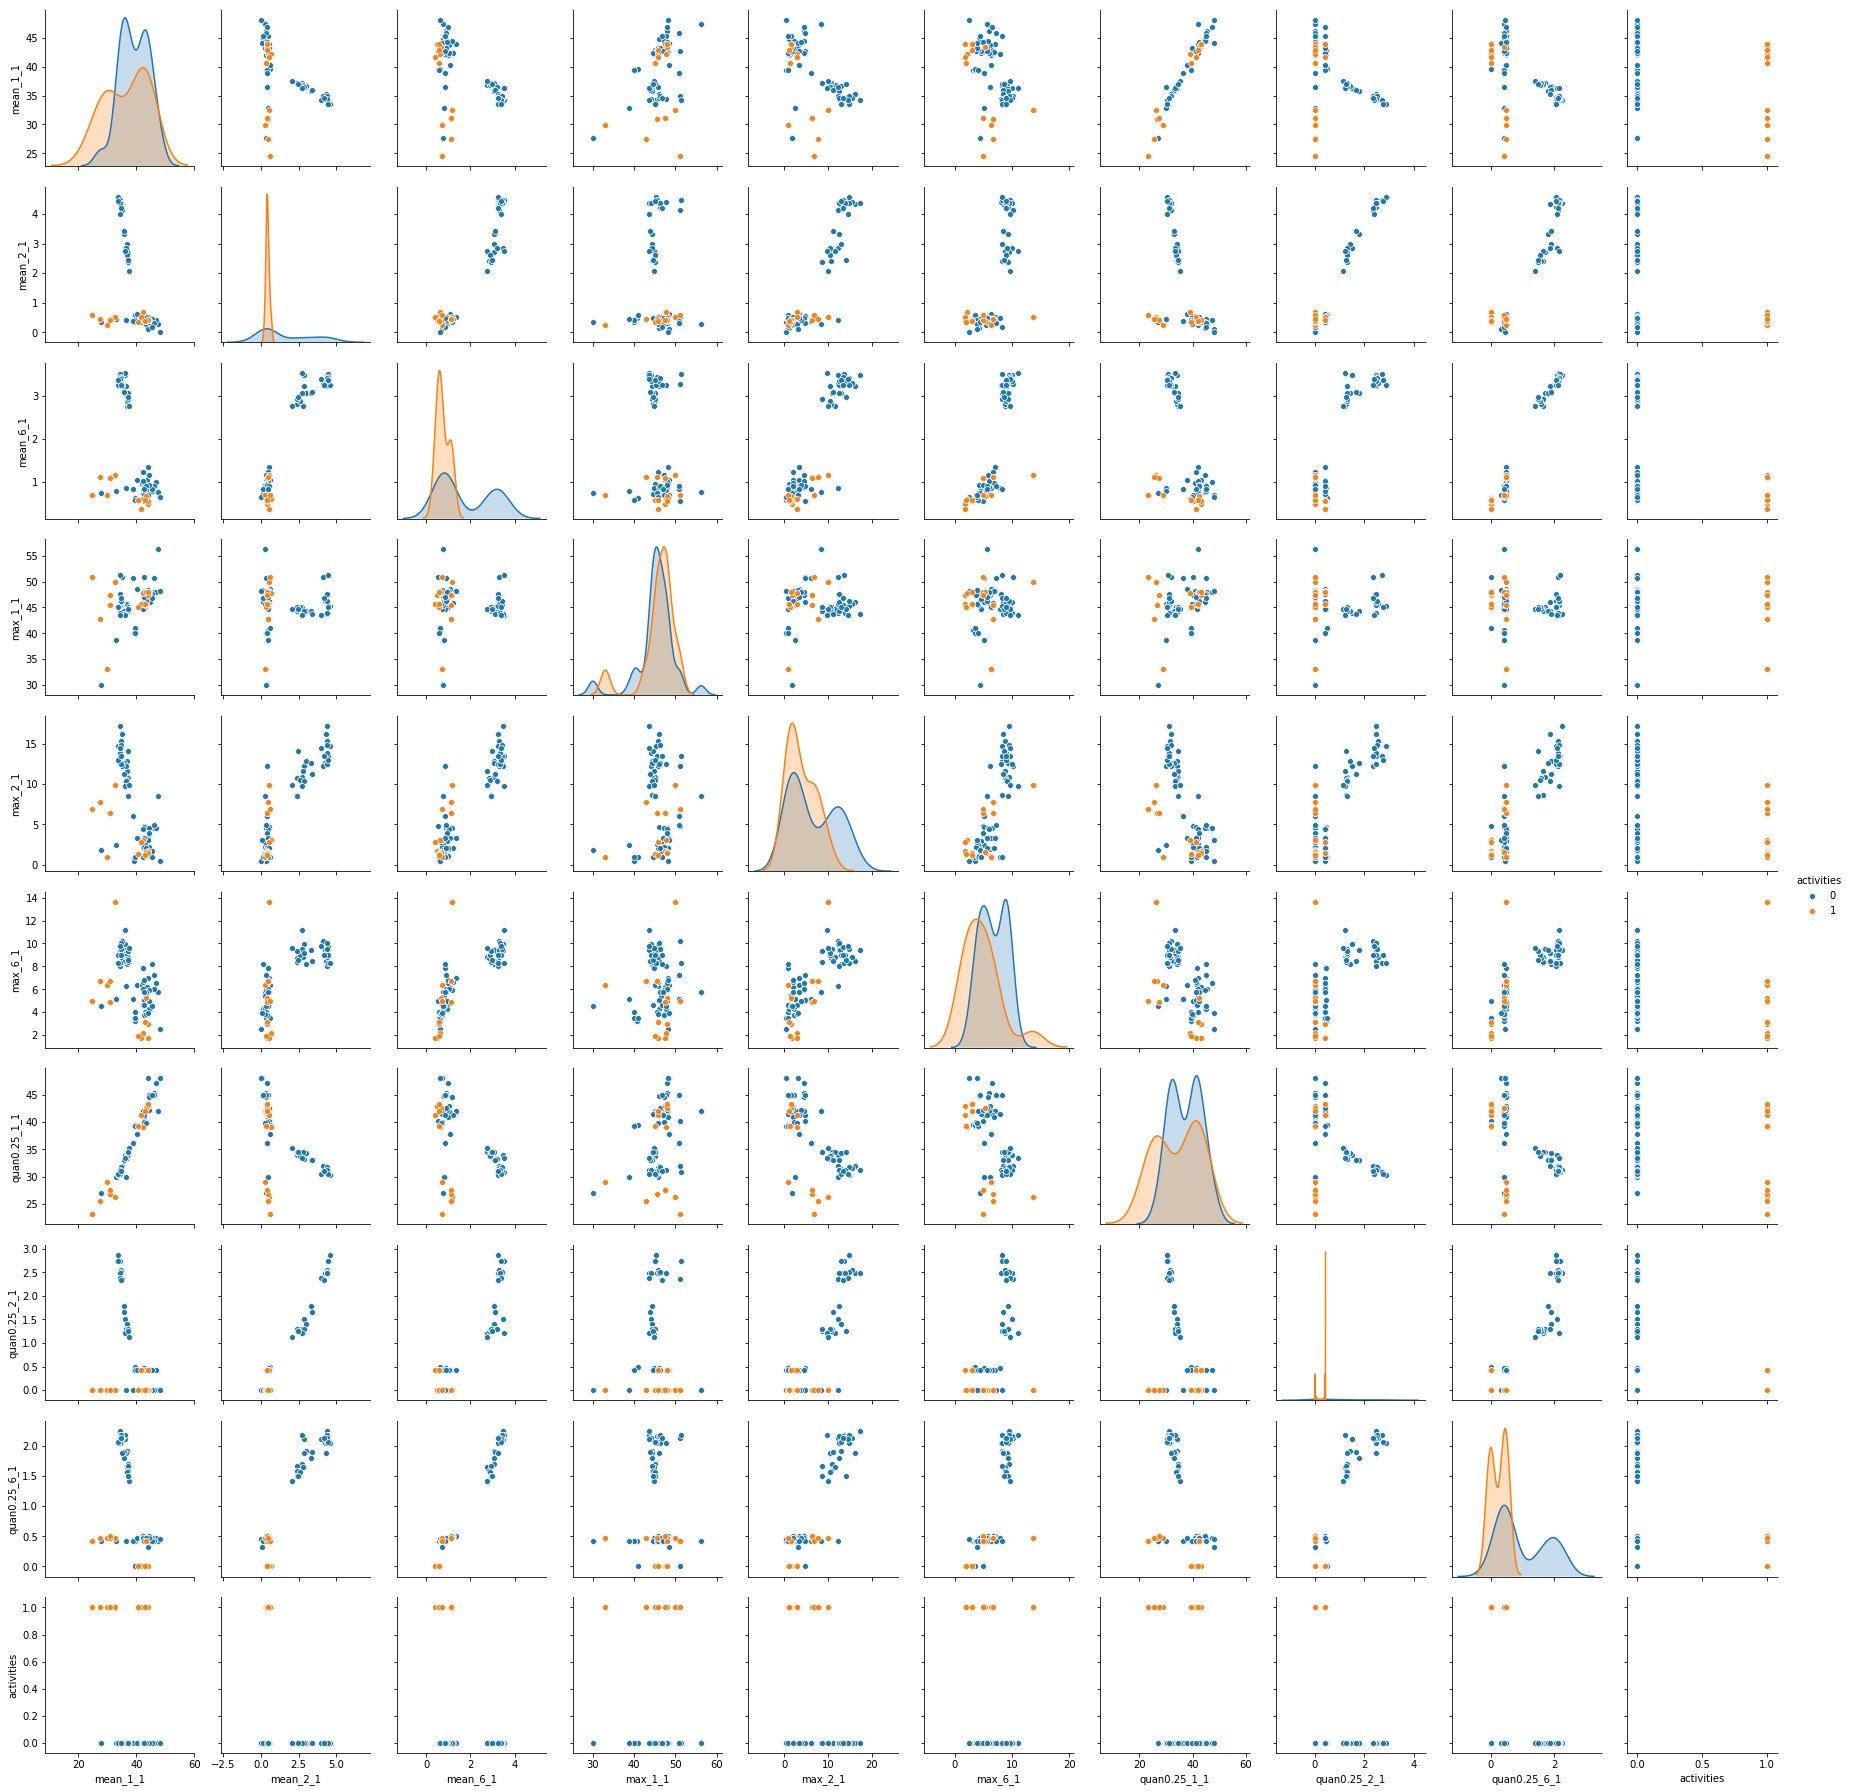

In [16]:
#scatter plot of bending vs other activities
sb.pairplot(data=total_features[scatter_row], hue = "activities")

In [17]:
split2_out_train = split_load(path_1, 2)
split2_out_test = split_load(path_2, 2)
total_features2 = pa.concat([split2_out_train,split2_out_test])
total_features2.reset_index(inplace = True, drop = True)
total_features2.activities = total_features2.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})


In [18]:
scatter_row = []
for f in select:
    for count in [1,2,6]:
        for k in [1,2]:
            scatter_row.append(f+"_"+str(count)+"_"+str(k))
scatter_row.append("activities")

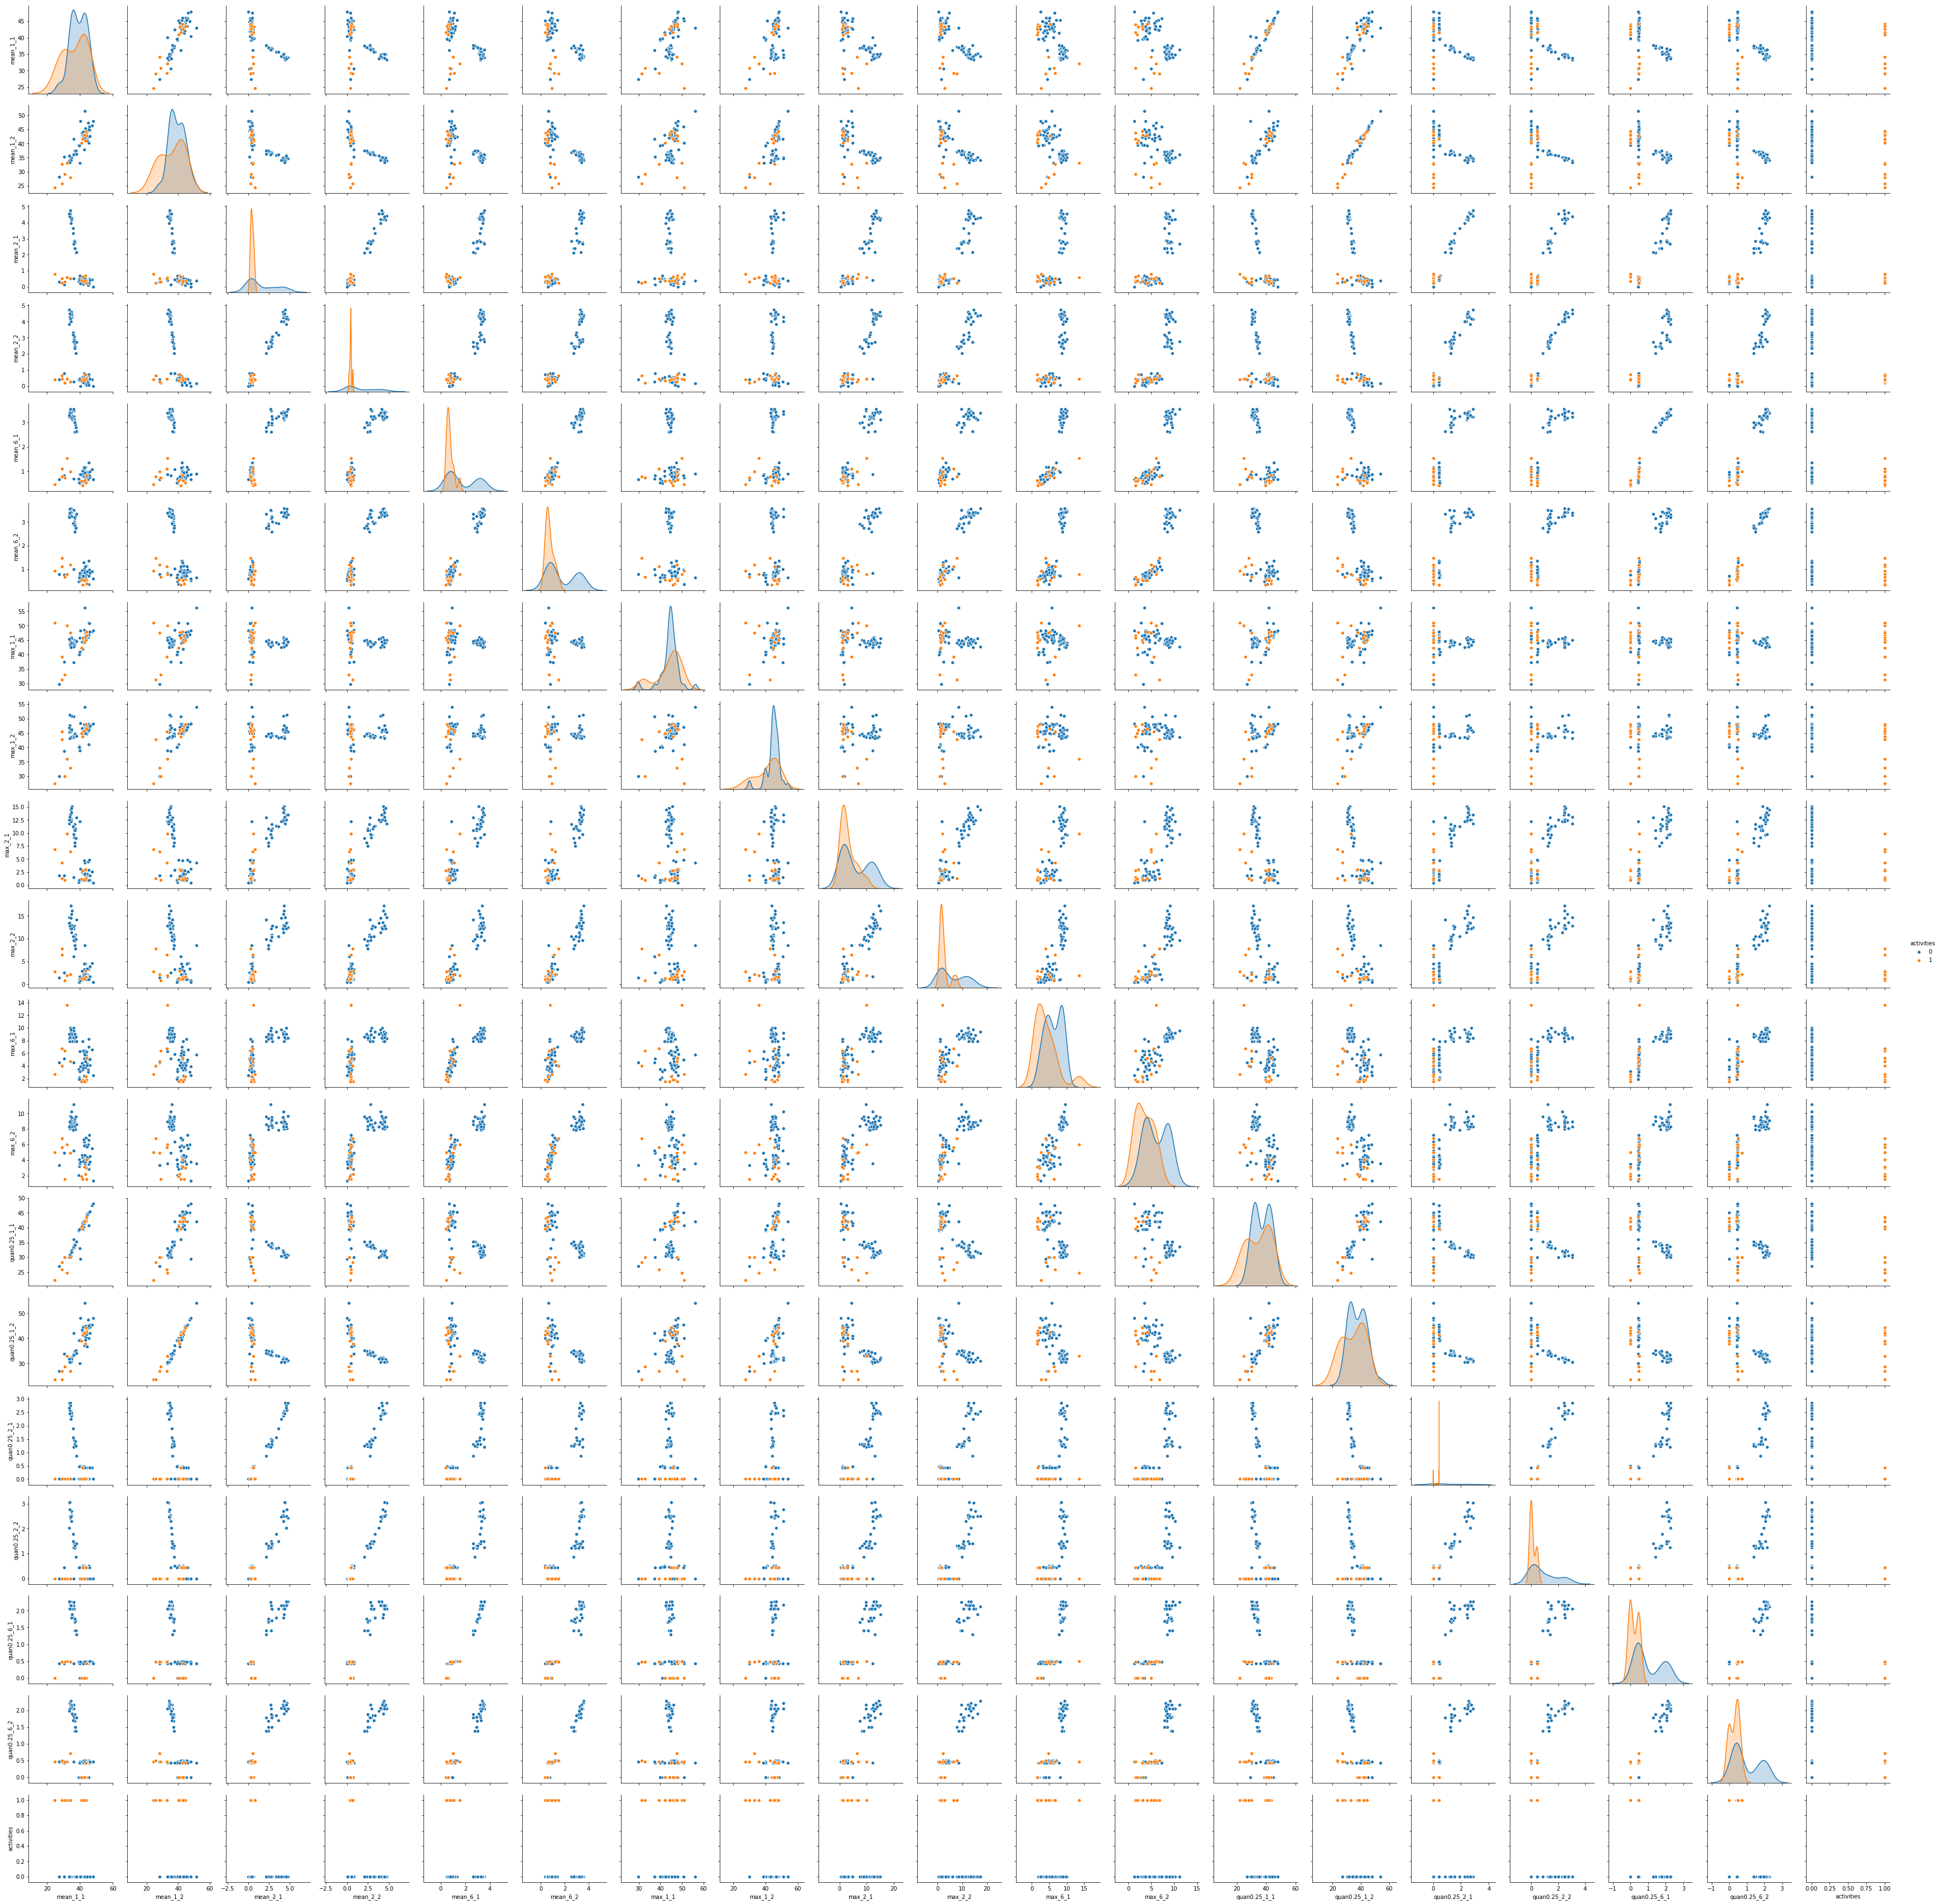

In [19]:
sb.pairplot(data=total_features2[scatter_row], hue = "activities")

In [24]:
list_score = pa.DataFrame(columns = ["Split", "Score"])

In [27]:
#Binary classification using Logistic regression
for l in range(1,21):
    train_data = split_load(path_1, l)
    X_train = train_data.drop(["activities"], axis = 1)
    Y_train = train_data.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
    K_fold = StratifiedKFold(n_splits=5,shuffle = True)
    scores = []
    for train_index, test_index in K_fold.split(X_train, Y_train):
        selector = RFECV(LogisticRegression(), step = 1)
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    list_score.loc[len(list_score)] = [int(l), avg_score]
    

In [28]:
list_score = list_score.sort_values(['Score'], ascending=False)
list_score

,Split,Score
10,11.0,0.991667
12,13.0,0.991667
18,19.0,0.991667
16,17.0,0.991667
9,10.0,0.991667
14,15.0,0.991667
8,9.0,0.983333
6,7.0,0.941667
7,8.0,0.941667
13,14.0,0.941667


In [30]:
best_L = int(list_score.iloc[1]["Split"])
best_L

13

In [31]:
X_train = split_load("train_data", best_L)
Y_train = X_train.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
X_test = split_load("test_data", best_L)
Y_test = X_test.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})

In [33]:
selector = RFECV(LogisticRegression(), step = 1)
selector = selector.fit(X_train.drop(["activities"], axis = 1), Y_train)
support = selector.get_support()
fu = []
for i in range(len(support)):
    if support[i] == 1:
        fu.append(X_train.columns[i])
co_eff = selector.estimator_.coef_
print("SUMMARY OF FEATURES : ")
print()
print("Features Selected and their coeff: ")
for i in range(len(fu)):
    print(fu[i], ":", co_eff[0][i])
print()
print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train.drop(["activities"], axis = 1))))
print("\nConfusion Matrix : Train data: ")
c = confusion_matrix(Y_train, selector.predict(X_train.drop(["activities"], axis = 1)))

print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_train, selector.predict(X_train.drop(["activities"], axis = 1))))
print("\nConfusion Matrix : Test data: ")
c = confusion_matrix(Y_test, selector.predict(X_test.drop(["activities"], axis = 1)))

print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])


SUMMARY OF FEATURES : 

Features Selected and their coeff: 
min_1_1 : -0.021034454537414954
max_1_1 : -0.00950766465272169
mean_1_1 : -0.010597472828322848
median_1_1 : -0.00831897824285963
sd_1_1 : -0.0006613988456193906
quan0.25_1_1 : -0.007396577687610167
quan0.75_1_1 : -0.013632498037861075
min_2_1 : -0.0006455422585946003
max_2_1 : -0.010218974841531269
mean_2_1 : -0.004975214803924016
median_2_1 : -0.004676179800908181
sd_2_1 : -0.0031759917783444505
quan0.25_2_1 : -0.0019299430589891121
quan0.75_2_1 : -0.007961666308413136
min_3_1 : -0.026960379437222418
max_3_1 : 0.0018680968545928354
mean_3_1 : -0.008474757130564912
median_3_1 : -0.009749799178935559
sd_3_1 : 0.005380194770228642
quan0.25_3_1 : -0.011143069289973766
quan0.75_3_1 : -0.0016124900829802636
min_4_1 : -0.001401581074606829
max_4_1 : -0.0023537180976016983
mean_4_1 : -0.003959303138414855
median_4_1 : -0.003610777936531075
sd_4_1 : -0.0002842367131505221
quan0.25_4_1 : -0.0029192278271470314
quan0.75_4_1 : -0.006015

min_1_11 : -0.0031477328223585978
max_1_11 : -0.020354127901270114
mean_1_11 : -0.019718038547843875
median_1_11 : -0.00705693454039231
sd_1_11 : -0.01307869599783473
quan0.25_1_11 : -0.010132176367133398
quan0.75_1_11 : -0.044399204118324265
min_2_11 : 0.0
max_2_11 : -0.03162070271115499
mean_2_11 : -0.0072344405456000035
median_2_11 : -0.003663831909415488
sd_2_11 : -0.005941336804865501
quan0.25_2_11 : -0.002688748233284827
quan0.75_2_11 : -0.011744195100661775
min_3_11 : 0.0014488933249263353
max_3_11 : 0.015529395254144228
mean_3_11 : -0.0005654102088219105
median_3_11 : -0.012467144886110032
sd_3_11 : -0.006836206405624954
quan0.25_3_11 : 0.016757978320735206
quan0.75_3_11 : -0.012649017546459857
min_4_11 : -2.945066597831716e-06
max_4_11 : 0.013294945169204746
mean_4_11 : -0.0062774861907620005
median_4_11 : -0.007271668847422675
sd_4_11 : -0.001573136932268784
quan0.25_4_11 : -0.003669546523398091
quan0.75_4_11 : -0.008701180109073739
min_5_11 : 0.037987228691030855
max_5_11 : 

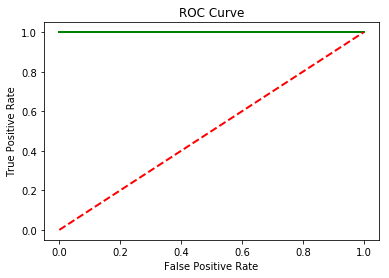

In [34]:
fp_r, tp_r = roc_curve(Y_test, selector.predict(X_test.drop(["activities"], axis = 1)))
roc_auc = auc(fp_r, tp_r)
plt.plot(fp_r, tp_r, color='green',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [36]:
#For balanced data
def balance_data(df):
    sample = RandomUnderSampler()
    x, y = sample.fit_sample(df.drop(["activities"], axis = 1), df.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0}))
    rows = []
    for i in range(len(x)):
        row = list(x[i])
        row.append(y[i])
        rows.append(row)
    train_data = pa.DataFrame(columns = df.columns, data = rows)
    X_train = train_data.drop(["activities"], axis = 1)
    Y_train = train_data.activities
    return X_train, Y_train

In [37]:
list2_score = pa.DataFrame(columns = ["Split", "Score"])

In [38]:
for l in range(1, 21):
    train_data = split_load("train_data", l)
    X_train, Y_train = balance_data(train_data)
    kf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        selector = RFECV(LogisticRegression(class_weight = "balanced"), step = 1)
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    list2_score.loc[len(list2_score)] = [int(l), avg_score]

In [39]:
list2_score = list2_score.sort_values(['Score'], ascending=False)
list2_score

,Split,Score
0,1.0,1.00
9,10.0,1.00
16,17.0,1.00
15,16.0,1.00
12,13.0,1.00
1,2.0,1.00
10,11.0,1.00
6,7.0,1.00
5,6.0,1.00
7,8.0,0.95


In [40]:
best_L2 = int(list2_score.iloc[0]["Split"])
best_L2

1

In [41]:
train_data = split_load("train_data", best_L2)
X_train, Y_train = balance_data(train_data)
test_data = split_load("test_data", best_L2)
X_test, Y_test = balance_data(test_data)

selector = RFECV(LogisticRegression(class_weight = "balanced"), step = 1)
selector = selector.fit(X_train, Y_train)

print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train)))
print()
print("TRAIN CONFUSION MATRIX")
c = confusion_matrix(Y_train, selector.predict(X_train))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_test, selector.predict(X_test)))
print()
print("TEST CONFUSION MATRIX")
c = confusion_matrix(Y_test, selector.predict(X_test))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])
print()


ROC AUC score : Train data: 
1.0

TRAIN CONFUSION MATRIX

True Negative =  9
False Negative =  0
True Positive =  9
False Positive =  0

ROC AUC score : Test data: 
1.0

TEST CONFUSION MATRIX

True Negative =  4
False Negative =  0
True Positive =  4
False Positive =  0



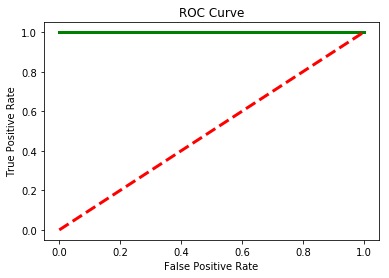

In [42]:
fp_r, tp_r, _ = roc_curve(Y_test, selector.predict(X_test))
roc_auc = auc(fp_r, tp_r)
plt.plot(fp_r, tp_r, color='green',lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [43]:
#l1 penalized regularization
list3_score = pa.DataFrame(columns = ["Split", "Score"])
for l in range(1,21):
    train_data = split_load("train_data", l)
    train_data.activities = train_data.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
    train_data = pa.DataFrame(columns = train_data.columns, data = MinMaxScaler().fit_transform(train_data))
    X_train = train_data.drop(["activities"], axis = 1)
    Y_train = train_data.activities
    kf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    list3_score.loc[len(list3_score)] = [int(l), avg_score]
list3_score = list3_score.sort_values(['Score'], ascending=False)
list3_score

,Split,Score
1,2.0,0.841667
2,3.0,0.833333
0,1.0,0.825000
5,6.0,0.825000
4,5.0,0.816667
6,7.0,0.816667
3,4.0,0.733333
12,13.0,0.733333
10,11.0,0.725000
7,8.0,0.716667


In [44]:
best_L3 = int(list3_score.iloc[0]["Split"])
best_L3

2

In [45]:
train_data = split_load("train_data", best_L3)
train_data.activities = train_data.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
train_data = pa.DataFrame(columns = train_data.columns, data = MinMaxScaler().fit_transform(train_data))
X_train = train_data.drop(["activities"], axis = 1)
Y_train = train_data.activities

test_data = split_load("test_data", best_L3)
test_data.activities = test_data.activities.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
test_data = pa.DataFrame(columns = test_data.columns, data = MinMaxScaler().fit_transform(test_data))
X_test = test_data.drop(["activities"], axis = 1)
Y_test = test_data.activities

In [46]:
selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
selector = selector.fit(X_train, Y_train)

print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train)))

print("\nTRAIN CONFUSION MATRIX")
c = confusion_matrix(Y_train, selector.predict(X_train))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_test, selector.predict(X_test)))

print("\nTEST CONFUSION MATRIX")
c = confusion_matrix(Y_test, selector.predict(X_test))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])
print()
print("BEST VALUE OF C : ")
print(selector.C_)


ROC AUC score : Train data: 
1.0

TRAIN CONFUSION MATRIX

True Negative =  60
False Negative =  0
True Positive =  9
False Positive =  0

ROC AUC score : Test data: 
0.875

TEST CONFUSION MATRIX

True Negative =  15
False Negative =  1
True Positive =  3
False Positive =  0

BEST VALUE OF C : 
[2.7825594]


In [47]:
multiclass_list = pa.DataFrame(columns = ["Split", "Score"])
for l in range(1,21):
    train_data = split_load("train_data", l)
    X_train = train_data.drop(["activities"], axis = 1)
    Y_train = train_data.activities
    kf = StratifiedKFold(n_splits=4)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        lr = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
        lr.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = lr.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        scores.append(score)
    avg_score = np.mean(scores)
    print([int(l), avg_score])
    multiclass_list.loc[len(multiclass_list)] = [int(l), avg_score]
multiclass_list = multiclass_list.sort_values(['Score'], ascending=False)
multiclass_list

[1, 0.8700980392156863]
[2, 0.7687908496732025]
[3, 0.7671568627450981]
[4, 0.7377450980392157]
[5, 0.798202614379085]
[6, 0.7532679738562091]
[7, 0.8259803921568627]
[8, 0.8267973856209151]
[9, 0.7679738562091504]
[10, 0.8112745098039216]
[11, 0.7965686274509803]
[12, 0.7826797385620915]
[13, 0.7826797385620916]
[14, 0.8120915032679737]
[15, 0.8406862745098039]
[16, 0.7965686274509803]
[17, 0.7973856209150327]
[18, 0.8259803921568627]
[19, 0.7549019607843136]
[20, 0.7671568627450981]


,Split,Score
0,1.0,0.870098
14,15.0,0.840686
7,8.0,0.826797
17,18.0,0.825980
6,7.0,0.825980
13,14.0,0.812092
9,10.0,0.811275
4,5.0,0.798203
16,17.0,0.797386
15,16.0,0.796569


In [48]:
best_L4 = int(multiclass_list.iloc[0]["Split"])
best_L4

1

In [49]:
train_data = split_load("train_data", best_L4)
X_train = train_data.drop(["activities"], axis = 1)
Y_train = train_data.activities
test_data = split_load("test_data", best_L4)
X_test = test_data.drop(["activities"], axis = 1)
Y_test = test_data.activities
selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
selector = selector.fit(X_train, Y_train)

print("TRAIN SCORE")
print(selector.score(X_train, Y_train))
print("TEST SCORE")
print(selector.score(X_test, Y_test))

TRAIN SCORE
1.0
TEST SCORE
0.7894736842105263


In [50]:
print("Confusion Matrix for train Data")
c = [[0 for activities in activity] for activities in activity]
pred = selector.predict(X_train)
for i in range(len(pred)):
    c[activity.index(Y_train[i])][activity.index(pred[i])] += 1
c = pa.DataFrame(columns = activity, data = c, index = activity)
print(c)
print()
print("Confusion Matrix for test Data")
c = [[0 for activities in activity] for activities in activity]
pred = selector.predict(X_test)
for i in range(len(pred)):
    c[activity.index(Y_test[i])][activity.index(pred[i])] += 1
c = pa.DataFrame(columns = activity, data = c, index = activity)
print(c)

Confusion Matrix for train Data
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         5         0        0      0        0         0        0
bending2         0         4        0      0        0         0        0
cycling          0         0       12      0        0         0        0
lying            0         0        0     12        0         0        0
sitting          0         0        0      0       12         0        0
standing         0         0        0      0        0        12        0
walking          0         0        0      0        0         0       12

Confusion Matrix for test Data
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         1        0      0        1         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      2        0       

In [51]:
#Naive Bayes classifier
naive_bayes_list = pa.DataFrame(columns = ["Split", "Multinomial Score", "Gaussian Score"])
for l in range(1, 21):
    train_data = split_load("train_data", l)
    X_train = train_data.drop(["activities"], axis = 1)
    Y_train = train_data.activities
    kf = StratifiedKFold(n_splits=4,shuffle = True)
    m_nb_scores = []
    g_nb_scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        m_nb = MultinomialNB()
        g_nb = GaussianNB()
        m_nb.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        g_nb.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        m_nb_score = m_nb.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        g_nb_score = g_nb.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        m_nb_scores.append(m_nb_score)
        g_nb_scores.append(g_nb_score)
    mnb_avg = np.mean(m_nb_scores)
    gnb_avg = np.mean(g_nb_scores)
    naive_bayes_list.loc[len(naive_bayes_list)] = [int(l), mnb_avg, gnb_avg]
naive_bayes_list

,Split,Multinomial Score,Gaussian Score
0,1.0,0.870915,0.884804
1,2.0,0.783497,0.799020
2,3.0,0.754085,0.695261
3,4.0,0.767974,0.727124
4,5.0,0.825980,0.752451
5,6.0,0.825980,0.741830
6,7.0,0.767974,0.709967
7,8.0,0.769608,0.680556
8,9.0,0.797386,0.694444
9,10.0,0.781046,0.723856
